In [1]:
using Revise
import Pkg
Pkg.activate(".")                        # your env
using CooperativeHuntingPkg              # load AFTER Revise


  Activating project at `~/Documents/CH_GroupFormation/CH_code/Julia_version`


In [2]:
push!(LOAD_PATH, pwd()) # put current directory on path
#using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=18,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=16,  # controls legend font
    linewidth=3,        # controls default line thickness
    grid = false,        # turns off grid in background
    dpi=200,
    fontfamily="Computer Modern" # font family that matches latex
)
using DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LinearAlgebra
using ForwardDiff #this should be able to numerically find a jacobian
using LaTeXStrings
using Polynomials
# saving with bif diagrams
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"
setprecision(BigFloat, 256)  # Set precision to 256 bits

256

# Label Dictionaries

In [3]:
# these were supposed to load with my package but i guess it didn't work
ylabel_dic = Dict(
    :N1 => L"N_1"*", Scaled Big Prey\nDensity",
    :N2 => L"N_2"*", Scaled Small Prey\nDensity",
    :mean_x => "Mean Experienced\nGroup Size, "*L"\bar{x}",
    :p => L"Predator density, $p$",
    :Nsum => "Sum of Prey Densities,\n"*L"N_1 + N_2",
    :g1 => L"g(1)",
    :g2 => L"g(2)",
    :g3 => L"g(3)"
)

param_label_dic = Dict(
    :α1_of_1 => L"\alpha_1(1)",
    :α2_of_1 => L"\alpha_2(1)",
    :s1 => L"s_1",
    :s2 => L"s_2",
    :H1a => L"H_{1a}",
    :H2a => L"H_{2a}",
    :H2b => L"H_{2b}",
    :A1 => L"Relative Attack Rate of Big Prey, $A_1$",
    :A2 => L"A_2",
    :η2 => L"Growth of Small Prey, $\eta_2$",
    :β2 => L"\beta_2",
    :x_max => L"x_{max}",
    :Tg => "Relative Group Dynamics \nTimescale, "*L"T_g",
    :d => L"d",
    :scale => L"Scale, $\beta_1/\beta_2$"
)

Dict{Symbol, AbstractString} with 15 entries:
  :A1      => L"Relative Attack Rate of Big Prey, $A_1$"
  :α1_of_1 => L"$\alpha_1(1)$"
  :β2      => L"$\beta_2$"
  :H2b     => L"$H_{2b}$"
  :Tg      => "Relative Group Dynamics \nTimescale, \$T_g\$"
  :d       => L"$d$"
  :A2      => L"$A_2$"
  :s1      => L"$s_1$"
  :H1a     => L"$H_{1a}$"
  :H2a     => L"$H_{2a}$"
  :scale   => L"Scale, $\beta_1/\beta_2$"
  :x_max   => L"$x_{max}$"
  :α2_of_1 => L"$\alpha_2(1)$"
  :η2      => L"Growth of Small Prey, $\eta_2$"
  :s2      => L"$s_2$"

# Functions

In [ ]:
# function find_mangel_clark(N1, N2, params)
#     # Mangel and Clark predicted that groups should grow until W(x^*) = W(1)
#     # Simplest way: iterate and stop when W(x) < W(1), then return x - 1
#     @unpack x_max = params
#     W_of_1 = fun_W(1, N1, N2, params)
#     for x in 2:x_max
#         W_of_x = fun_W(x, N1, N2, params)
#         if W_of_x < W_of_1
#             return x - 1
#         end
#     end
#     return x_max  # If reach x_max
# end

# function get_g_equilibria(P, N1, N2, params)
#     """
#     Finds all the g(x) equilibria for a certain p, N1, N2 combination.
#     Assumes population sizes are constant.

#     Returns gvec
#     """
#     x_max = params[:x_max]
#     xvec = 1:x_max

#     # Get the root for g(1)

#     W = fun_W(xvec,N1,N2,params)
#     S_of_1_x = fun_S_given_W(W[1], W, params)
#     S_of_x_1 = 1 .- S_of_1_x
#     c_vec = S_of_x_1./(xvec.*S_of_1_x)
#     c_vec[2] = c_vec[2]/2    
#     # Compute coefficients for g(1)
#     coefficients = [x * prod(c_vec[1:x]) for x in xvec]  # Reverse order
#     coeff_full = vcat(-P, coefficients)  # Append -P to the coefficients
#     # Find roots
#     roots_all = roots(Polynomials.Polynomial(coeff_full))
    
#     # Filter real positive roots. there should only be one.
#     g1 = real(filter(x -> isreal(x) && real(x) > 0, roots_all)[1])

#     # Compute g(x) for each g1 root
#     gvec = [prod(c_vec[1:x]) * g1^x for x in xvec]

#     return gvec
# end


# function classify_equilibrium_g(g, N1, N2, params)
#     """
#     Compute the eigenvalues of the Jacobian matrix for just the dynamics of dg(x)/dt.
#     Returns:
#     - "Stable (attractive)"
#     - "Unstable"
#     - "Marginally stable (needs further analysis)"
#     - "Indeterminate stability (needs further analysis)"
#     """
#     # Compute the Jacobian matrix for group dynamics
#     J = ForwardDiff.jacobian(u -> fun_dg_nopop(u, params, 1),g[1:end-1])
#     #J = Jacobian_g(N1, N2, g, params)

#     # Compute the eigenvalues of the Jacobian matrix
#     eigenvalues = eigen(J).values
#     # Check the real parts of the eigenvalues
#     real_parts = real.(eigenvalues)

#     # Classify the stability based on the real parts of the eigenvalues
#     if all(real_parts .< 0)
#         return true
#     else
#         return false
#     end
# end
# function update_params(paramkey::Symbol, param, params_base::Dict{Symbol, Any})
#     # Create a copy of the base parameters
#     params = deepcopy(params_base)
    
#     # Update the parameter specified by paramkey with the new value
#     params[paramkey] = param
    
#     # Scale the parameters
#     params = scale_parameters(params)
    
#     return params
# end
# function bifurcation_g_input(p, N1, N2, paramkey::Symbol, 
#     paramvec, params_base::Dict{Symbol, Any})
#     #=
#     Loop over elements of paramvec, 
#     finding the g equilibrium and stability for each
#     paramater value
#     =#
#     x_max = params_base[:x_max]
#     # Initialize arrays to store equilibrium g values and their corresponding stability
#     results_g = zeros(length(paramvec), x_max)  # 2D array
#     stability_results = Vector{Bool}(undef, length(paramvec))

#     # Iterate over paramvec
#     for (i, param) in enumerate(paramvec)
#         # Update parameters
#         params = update_params(paramkey, param, params_base)

#         # Find the single equilibrium g vector
#         gvec = get_g_equilibria(p, N1, N2, params)

#         # Get stability
#         stability = classify_equilibrium_g(gvec, N1, N2, params)

#         # Store results
#         results_g[i, :] = gvec  # Store the vector as a row
#         stability_results[i] = stability
#     end

#     return Dict(
#         :results_g => results_g, 
#         :stability_results => stability_results
#         )
# end

# function get_x_maximizes_pc_fitness(N1, N2, params)
#     xvec = 1:params[:x_max]
#     W_of_x = fun_W(xvec, N1, N2, params)  # Use fun_W instead of per_capita_fitness_from_prey_non_dim
#     max_index = argmax(W_of_x)
#     return max_index
# end


plot_leading_eval (generic function with 1 method)

# Plotting Functions

In [4]:

function plot_actual_vs_optimal_just_g(
    P, N1, N2, paramkey::Symbol, paramvec, 
    params_base, bifurcation_dic
    )
    """
    Plots the mean experienced group size, the equilibrium group size predicted by Mangel and Clark, 
    and the group size that maximizes per capita fitness.

    Arguments:
        paramkey::Symbol: Label of parameter on the x-axis.
        paramvec::Vector: Parameter values shown.
        params_base::Dict: Dictionary of other parameters.
        bifurcation_dic::Dict: Output from `bifurcation_g_input`.

    Returns:
        Tuple (fig, ax)
    """
    @unpack x_max = params_base
    # Set up figure
    fig = plot()
    
    # Iterate over paramvec and get the optimal and Mangel + Clark group sizes
    x_list_mangel_clark = []
    x_list_optimal = []
    params = deepcopy(params_base)
    for param in paramvec
        params[paramkey] = param
        params = scale_parameters(params)
        x_mc = find_mangel_clark(N1, N2, params)
        push!(x_list_mangel_clark, x_mc)
        x_opt = get_x_maximizes_pc_fitness(N1, N2, params)
        push!(x_list_optimal, x_opt)
    end

    # Plot optimal and Mangel + Clark group sizes
    plot!(
        paramvec, x_list_optimal, color=:cyan, 
        lw=3, label=L"$x$ maximizing $W(x)$"
        )
    plot!(
        paramvec, x_list_mangel_clark, 
        color=:blue, lw=3, 
        label=L"Clark & Mangel $x*$"
        )

    # Calculate mean experienced group size from the results_g element in bifurcation_dic
    x = 1:x_max
    group_densities = bifurcation_dic[:results_g]
    prob_experience_x = group_densities' .* x ./ P

    # Compute E[X] (mean experienced group size)
    mean_exp_x = sum(prob_experience_x .* x, dims=1) # sum over columns

    # Most frequent group size
    most_freq_x = getindex.(Tuple.(argmax(prob_experience_x, dims=1)),1)

    # Plot mean experienced and most frequent group sizes
    plot!(
        paramvec, mean_exp_x', color=:black, 
        lw=3, label=L"Mean Experienced $x$")
    plot!(
        paramvec, most_freq_x', color=:magenta, 
        lw=3, label=L"Most Freq. $x$"
        )

    plot!(xlabel = param_label_dic[paramkey], ylabel = L"Group size, $x$",
    guidefontsize=18)
    return fig
end

function plot_line_g(paramkey::Symbol, x_max, paramvec, results_g, stability_results, P;
    group_size_last = 6)
    """
    Plots equilibrium g(x) vs. parameter values with:
    - Solid lines for stable points.
    - Dashed lines for unstable points.
    - Colors indicating different group sizes.

    Arguments:
        paramkey::Symbol: Label of parameter on the x-axis.
        x_max::Int: Maximum group size.
        paramvec::Vector: Vector of parameter values.
        results_g::Matrix: Matrix of g(x) values (rows = params, cols = group sizes).
        stability_results::Vector{Bool}: true if stable, false otherwise.

    """
    fig = plot()
    #group_size_last = min(6, x_max)
    group_sizes = 1:group_size_last

    # get probability experienced group size of X
    xvec = 1:x_max
    prob_experience_x = results_g' .* xvec ./ P
    
    colors = [:red, :orange, :magenta, :purple,
    :blue, :lightblue, :teal, :brown, :black, :gold]
    for x in group_sizes
        px = prob_experience_x[x,:] #CHECK
        # Separate stable and unstable points
        #=plot_segments!(
            paramvec, gx, stability_results; 
            color = x, plot_legend = false)=#
        plot!(
            paramvec, px, color = colors[x], lw=3,
            label = L"x=%$x"*"  ")
        #plot!([],[],color = x, label = L"x=%$x", legend = true)
    end

    xlabel!(L"Scale, $\beta_1/\beta_2$")
    ylabel!("Prob. experience \ngroup of size "*L"$x$")#L"g(x)")
    return fig
end

function plot_leading_eval(paramvec, out_dict, params_base)
    # assumes we're changing scale
    params = deepcopy(params_base)
    leading_eigenvalues = []  # Array to store the leading eigenvalue for each row
    g_mat = out_dict[:results_g]
    for i in 1:size(g_mat, 1)
        scale = paramvec[i]
        params[:scale] = scale 
        params = scale_parameters(params)
        g = g_mat[i, :]  # Extract the current row (group densities)
        
        # Compute the Jacobian matrix
        J = Jacobian_g(N1, N2, g, params)
        
        # Compute the eigenvalues of the Jacobian matrix
        eigenvalues = eigen(J).values
        
        # Find the eigenvalue with the largest real part
        max_real_eigenvalue = eigenvalues[argmax(real.(eigenvalues))]
        
        # Store the leading eigenvalue
        push!(leading_eigenvalues, max_real_eigenvalue)
    end
    plt = plot()
    # Print the leading eigenvalues
    plot!(
        paramvec, leading_eigenvalues, label = nothing,
        ylabel="Leading Eigenvalue")
    return (plt, leading_eigenvalues)
end
function heatmap_bif_g1(gmat, P::Number, N1::Number, N2::Number, paramkey, paramvec, params_base)
    #=
    uses a heatmap to plot Prob(x), if P, N1, N2 constant
    uses the function fun_W to get W and thus find the highest x for which W(x) >= W(1) (called x^*)
        and the x that maximizes W (called x_0)
    =#

    prob = get_prob_in_x(gmat, P, params_base[:x_max])
    hm = heatmap(
        paramvec,     # x = rows
        1:size(prob,2),     # y = columns
        prob',              # transpose so rows map to x
        c = cgrad(:grays, rev=true),    # high values → dark
        #colorrev=false,      # darker = higher
        xlabel=param_label_dic[paramkey],
        ylabel=L"Group size, $x$",
        title="Probability heatmap",
        ylims = [1, params_base[:x_max]]
    )
    # find x_mc
    x_mc_vec = similar(paramvec)
    x_opt_vec = similar(paramvec)
    for (i,param) in enumerate(paramvec)
            params = update_params(paramkey, param, params_base)
            print("hello")
            W = fun_W(1:params[:x_max],N1,N2,params)

            # give the index of the first group size x, where x > 1, such that W(x) >=W(1) and W(x+1)<W(1).
            # otherwise (if the fitness is > W(1) for all group sizes) give the maximum group size
            x_mc_vec[i] = any(W[2:end] .< W[1]) ? findfirst( W[2:end] .< W[1]) : params[:x_max]
            x_opt_vec[i] = argmax(W)
    end
    plot!(paramvec, x_mc_vec, label = L"x^*")
    plot!(paramvec, x_opt_vec, label = L"x_0")
    return hm
end

heatmap_bif_g1 (generic function with 1 method)

# Params base

In [5]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 1.0,
    :A1 => 0.5,
    :A2 => 0.5,
    :η2 => 0.5,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :d => 100.0,
    :scale => 5.0,
    :Tg => 1,
    :P => 10,#:P => 3.0,
    :N1 => 1.0,
    :N2 => 0.5
)

Dict{Symbol, Any} with 19 entries:
  :A1          => 0.5
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 1.0
  :d           => 100.0
  :Tg          => 1
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 5.0
  :P           => 10
  :x_max       => 10
  :α2_of_1     => 0.95
  :η2          => 0.5
  :N2          => 0.5
  :N1          => 1.0
  :α2_fun_type => "constant"
  :s2          => 2.0

# $d=100$

## Plot W

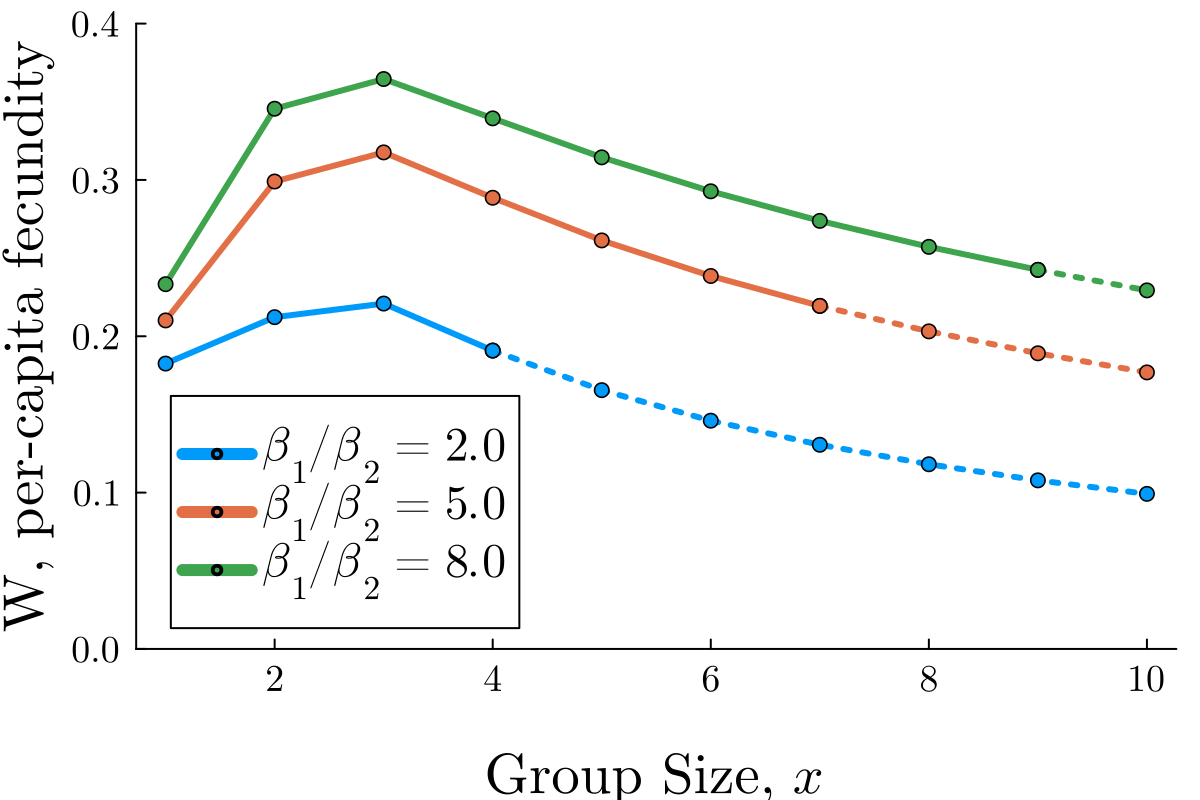

In [6]:
x = collect(1.0:1.0:10.0)
@unpack N1, N2, scale = params_base

scale_list = [2.0, 5.0, 8.0]
fig = plot()
for (i, scale) in enumerate(scale_list)
    params = deepcopy(params_base)
    params[:scale] = scale
    params = scale_parameters(params)
    W = fun_W(x, N1, N2, params)
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)
    plot!(
        1:x_end_above, W[1:x_end_above], 
        color = i, marker = :circle,
        label = L"$\beta_1/\beta_2 = %$scale$")
    plot!(
        x[x_end_above:end],W[x_end_above:end], 
        color = i, marker = :circle, linestyle = :dot,
        label = "")

end
plot!(
    xlab = "\n"*L"Group Size, $x$",
    ylab = "W, per-capita fecundity",
    ylim = [0,0.4],
    legend=:bottomleft
    )
savefig(fig, bif_fig_path*"W_only_groups_vs_scale.pdf")

fig


## Plot equilibria

hellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohello

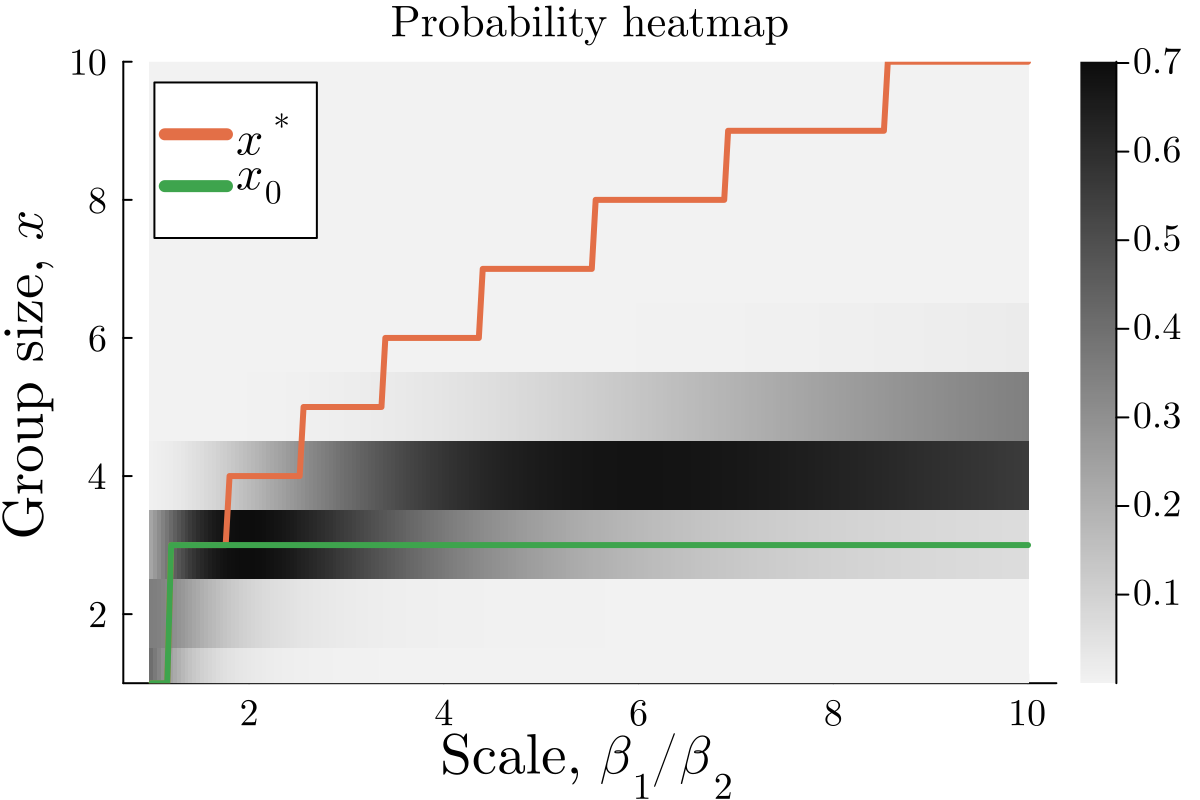

In [7]:
paramkey = :scale
paramvec = collect(1.0:0.04:10.0)
@unpack P, N1, N2, x_max = params_base

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
gmat = out_dict[:results_g]
hm = heatmap_bif_g1(gmat, P, N1, N2, paramkey, paramvec, params_base)
savefig(hm, bif_fig_path*"equilibria_only_groups_vs_scale.pdf")
hm


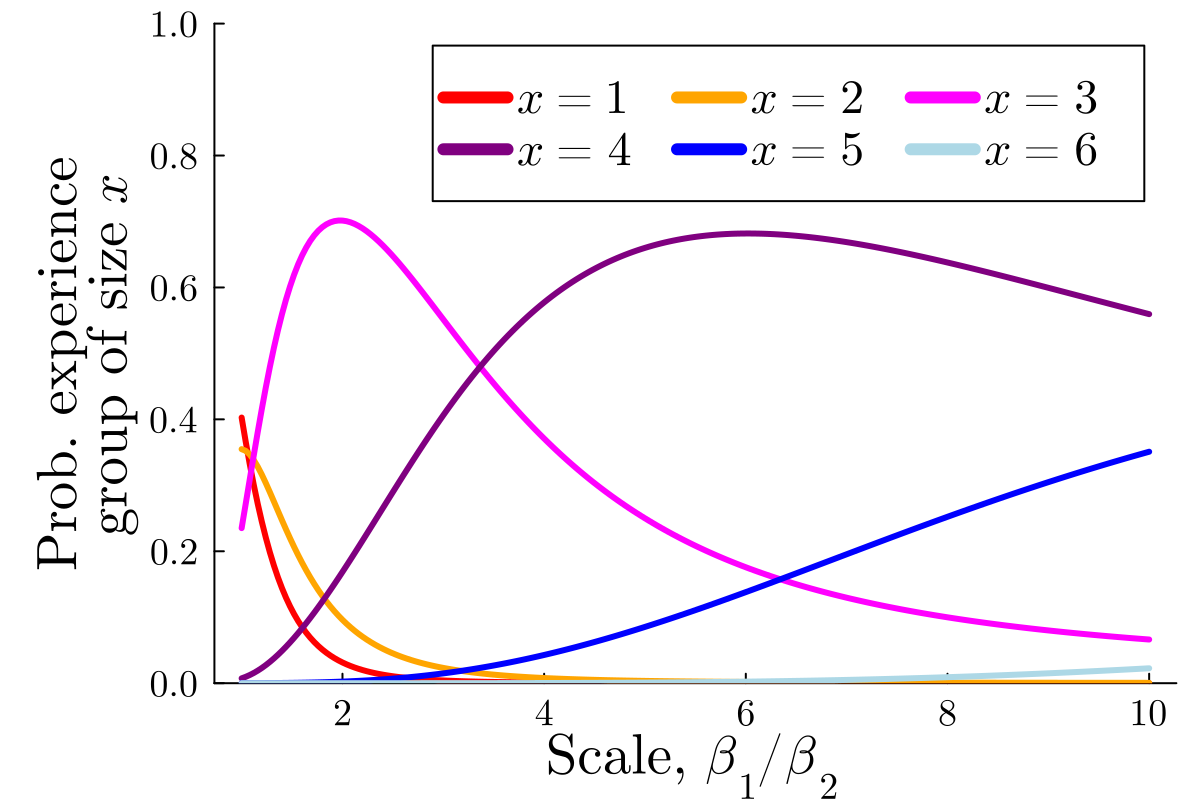

In [8]:

paramkey = :scale
paramvec = collect(1.0:0.04:10.0)
@unpack P, N1, N2, x_max = params_base

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results], P
    )
plot!(left_margin=6mm, ylim = [0,1.0], legend_column=3)
savefig(fig, bif_fig_path*"equilibria_only_groups_vs_scale.pdf")
fig


In [9]:
sum(out_dict[:stability_results])

226

## Check that all equilibria are stable

0

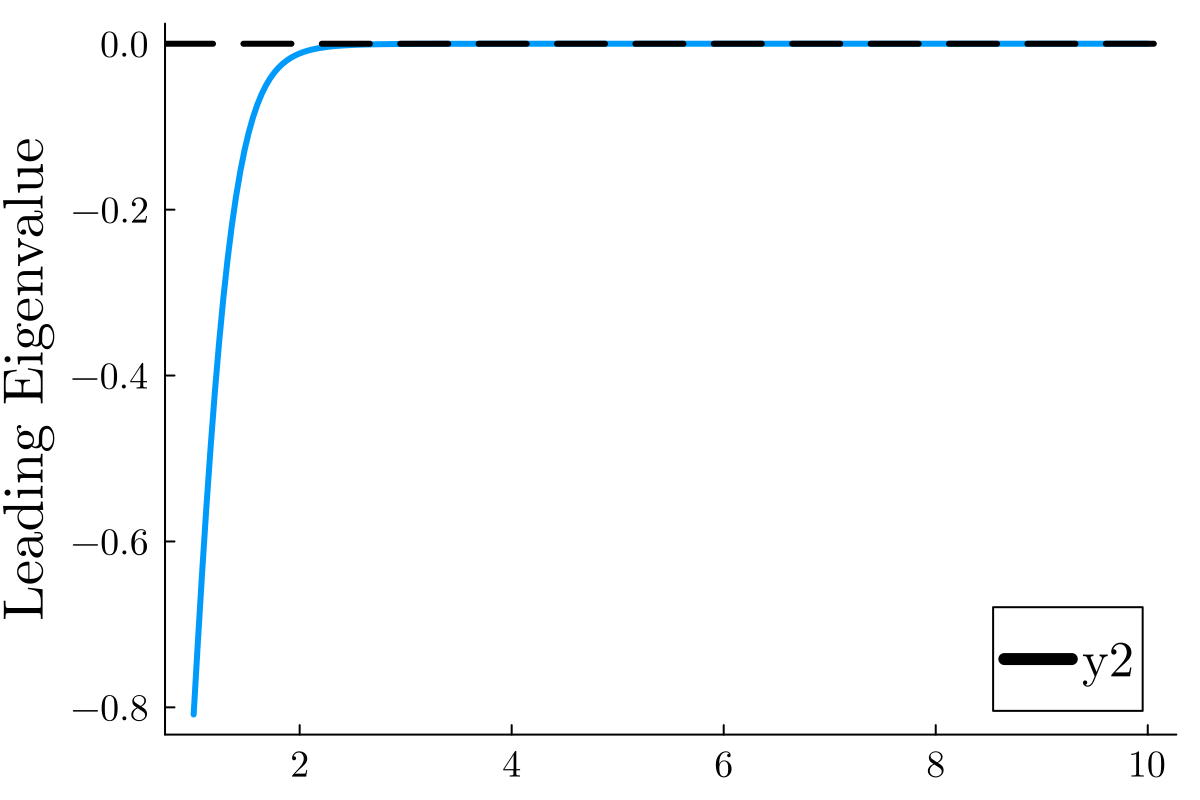

In [10]:
(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))
plt

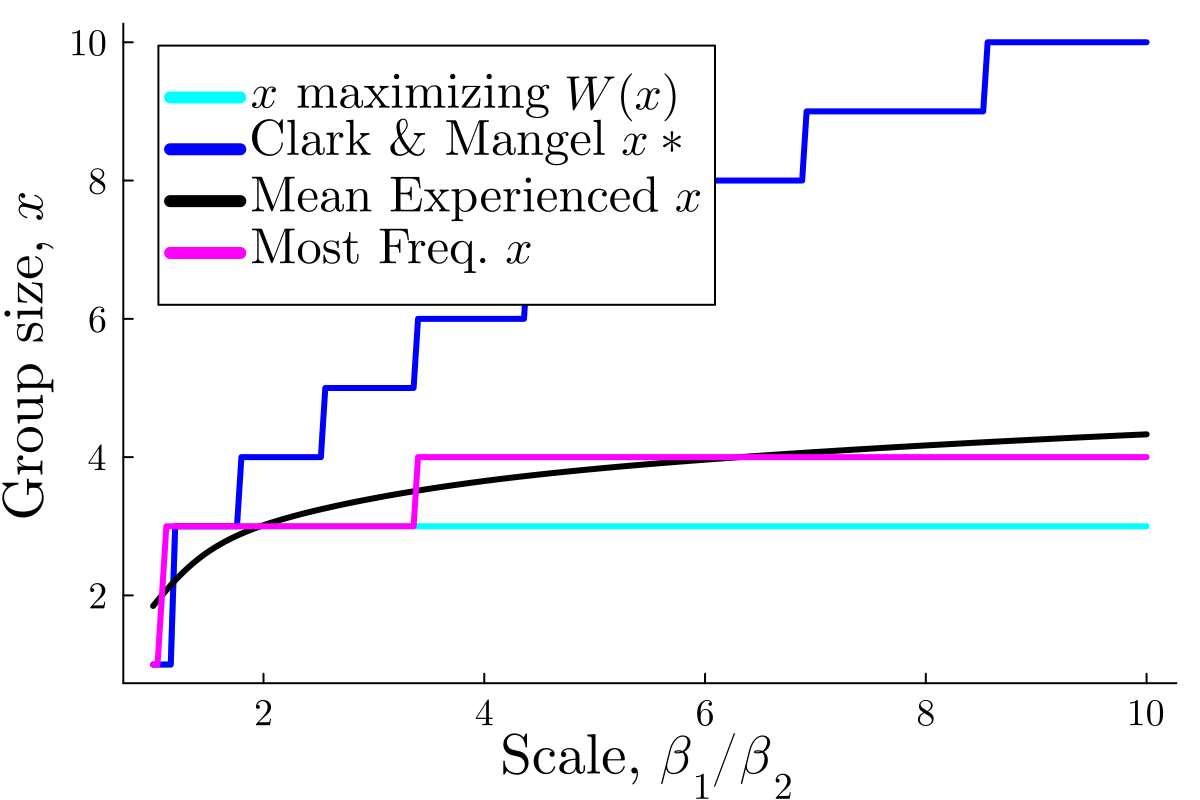

In [11]:
paramkey = :scale
fig = plot_actual_vs_optimal_just_g(
    P, N1, N2, paramkey, 
    paramvec, params_base, out_dict)
savefig(fig, bif_fig_path*"optimal_comparison_only_groups_vs_scale.pdf")
fig

# Only Big Prey

In [13]:
params_1prey = deepcopy(params_base)
params_1prey[:N2] = 0

0

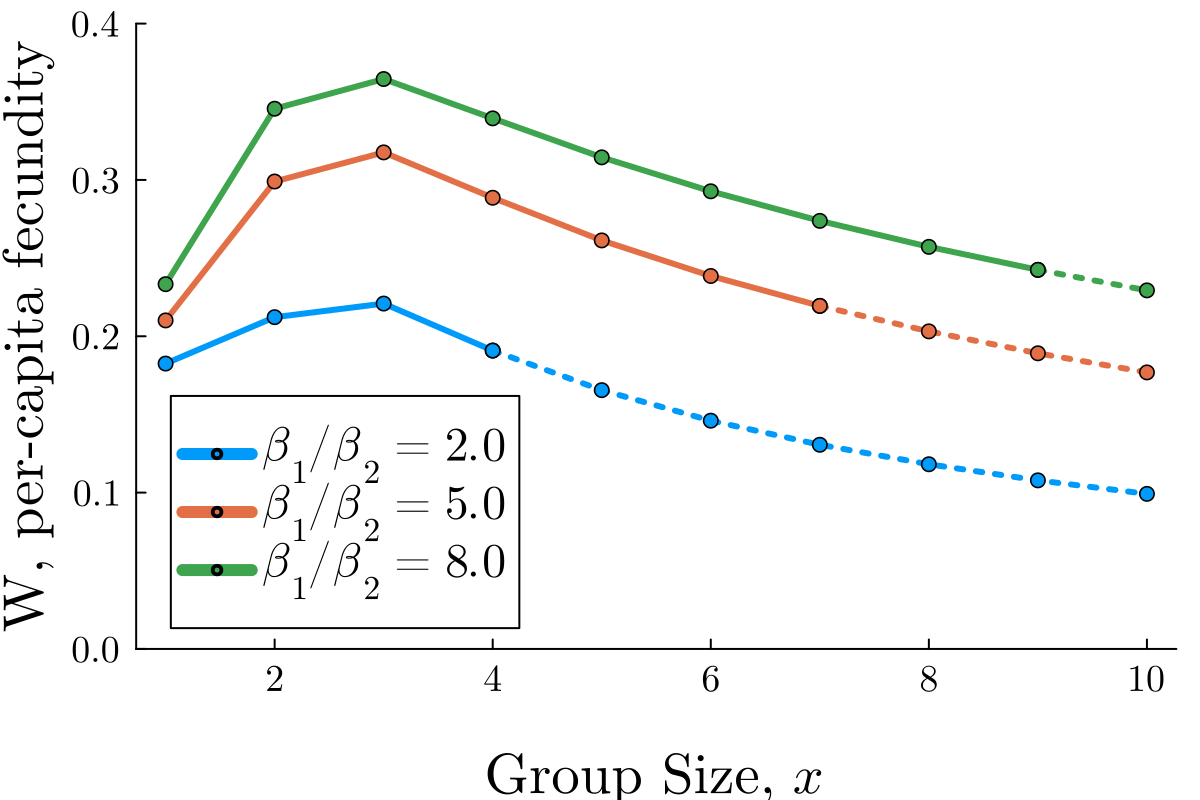

In [15]:
# plot W
x = collect(1.0:1.0:10.0)
@unpack N1, N2, scale = params_base

scale_list = [2.0, 5.0, 8.0]
fig = plot()
for (i, scale) in enumerate(scale_list)
    params = deepcopy(params_1prey)
    params[:scale] = scale
    params = scale_parameters(params)
    W = fun_W(x, N1, N2, params)
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)
    plot!(
        1:x_end_above, W[1:x_end_above], 
        color = i, marker = :circle,
        label = L"$\beta_1/\beta_2 = %$scale$")
    plot!(
        x[x_end_above:end],W[x_end_above:end], 
        color = i, marker = :circle, linestyle = :dot,
        label = "")

end
plot!(
    xlab = "\n"*L"Group Size, $x$",
    ylab = "W, per-capita fecundity",
    ylim = [0,0.4],
    legend=:bottomleft
    )
#savefig(fig, bif_fig_path*"W_only_groups_vs_scale.pdf")

fig


hellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohello

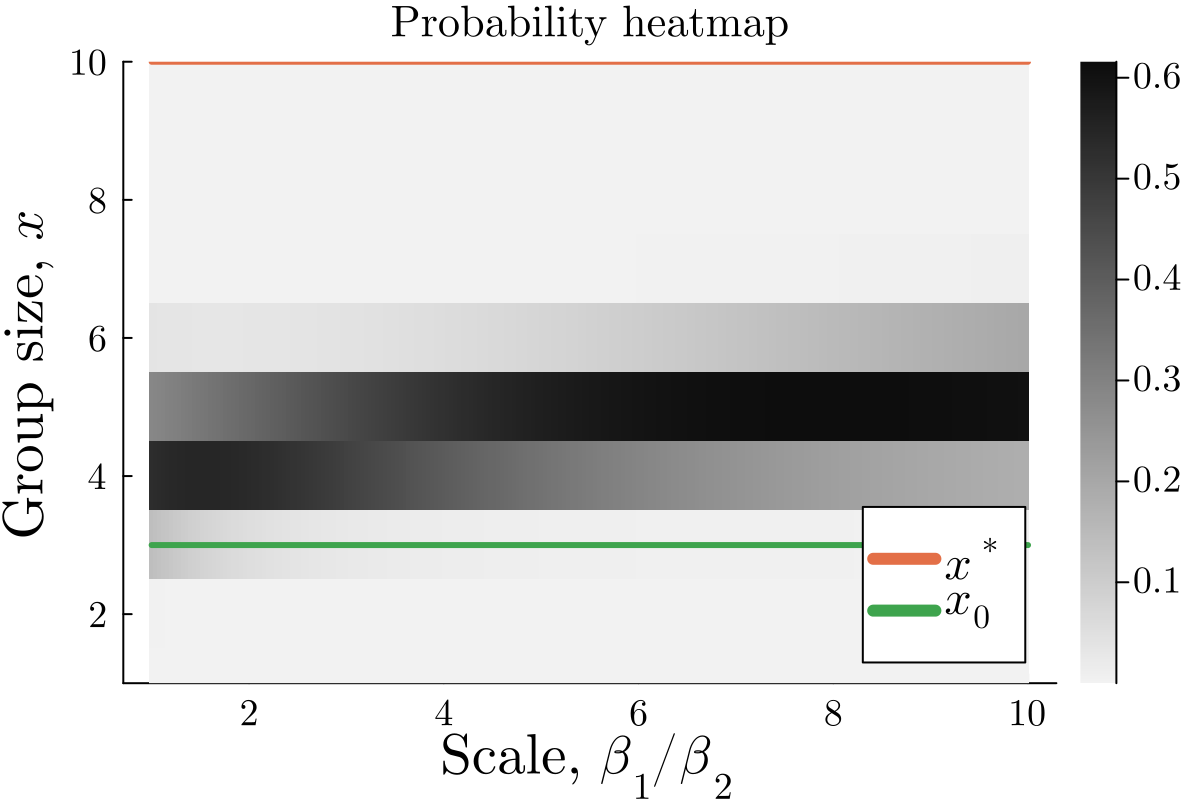

In [16]:
paramkey = :scale
paramvec = collect(1.0:0.04:10.0)
@unpack P, N1, N2, x_max = params_1prey

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_1prey)
gmat = out_dict[:results_g]
hm = heatmap_bif_g1(gmat, P, N1, N2, paramkey, paramvec, params_1prey)
savefig(hm, bif_fig_path*"equilibria_only_groups_vs_scale.pdf")
hm


# Simple W - small A

In [ ]:

params_simple = Dict(
    :α1_of_1 => 0.05,
    :A1 => 0.5,
    :s1 => 2.0,
    :x_max => 10,
    :d => 100.0,
    :P => 10,#:P => 3.0,
     
    :H1a => 0.0,
    :H1b => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A2 => 0.5, # doesn't matter
    :η2 => 0.5, # doesn't matter
    :β1 => 1.0,
    :β2 => 1.0, 
    :α2_fun_type => "constant",
    :Tg => 1,  
    :scale => 1.0 # eta1, eta2 don't matter here anyway, H = 0, so won't affect anything
)

Dict{Symbol, Any} with 20 entries:
  :A1          => 0.5
  :α1_of_1     => 0.05
  :Tg          => 1
  :H2b         => 0.0
  :d           => 100.0
  :β1          => 1.0
  :H1b         => 0.0
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 1.0
  :P           => 10
  :x_max       => 10
  :α2_of_1     => 0.95
  :η2          => 0.5
  :N2          => 0
  :N1          => 1.0
  :α2_fun_type => "constant"
  :β2          => 1.0

## vs s

hellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohello

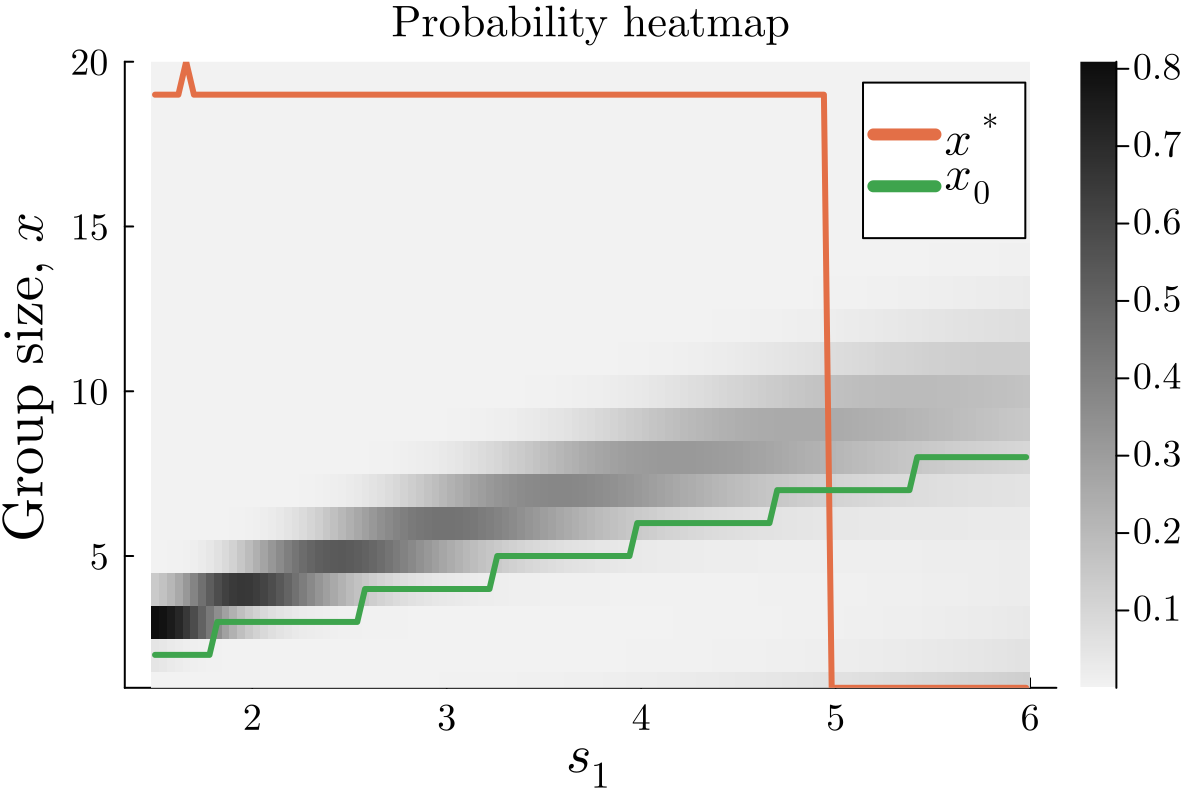

In [26]:
paramkey = :s1
paramvec = collect(1.5:0.04:6.0)
params = deepcopy(params_simple)
params[:x_max] = 20

@unpack P, N1, N2, x_max = params

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
gmat = out_dict[:results_g]
plot!(xlabel = "\n"*L"Critical group size, $s_1$")

hm = heatmap_bif_g1(gmat, P, N1, N2, paramkey, paramvec, params)
#savefig(hm, bif_fig_path*"equilibria_only_groups_vs_scale.pdf")
savefig(hm, bif_fig_path*"equilibria_simpleW_vs_s_smallA.pdf")

hm


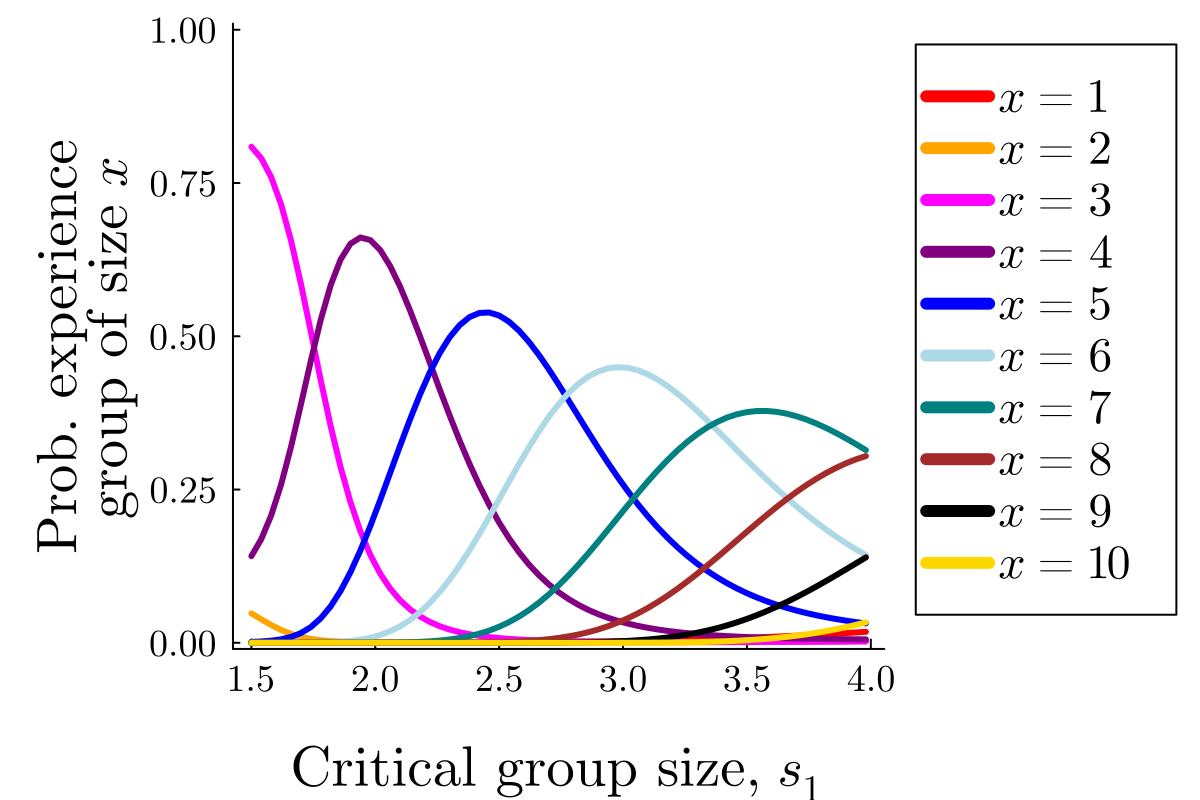

In [ ]:
paramkey = :s1
paramvec = collect(1.5:0.04:4.0)

params = deepcopy(params_simple)
params[:x_max] = 20
@unpack P, N1, N2, x_max = params

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results], P; group_size_last = 10
    )
plot!(xlabel = "\n"*L"Critical group size, $s_1$")
plot!(ylim=[-0.01,1.01])
plot!(
    fig, left_margin=6mm, 
    legend = :outertopright)

#savefig(fig, bif_fig_path*"equilibria_simpleW_vs_s_smallA.pdf")
fig



In [24]:
params = deepcopy(params_simple)
params[:s1] = 5.0
W = fun_W(1:20,N1,N2,params)
W

20-element Vector{Float64}:
 0.025000000000000005
 0.02475125267427927
 0.031100916143895128
 0.04048192756817423
 0.05
 0.05634538162121718
 0.05809960736690208
 0.05631218683143018
 0.052777777777777785
 0.048770536798669065
 0.04491225191596229
 0.04142707842249657
 0.03835529111772206
 0.03566696290395146
 0.03331216343189138
 0.03124049076795696
 0.029407477276624936
 0.027775838151899462
 0.026314909308320356
 0.024999599495825104

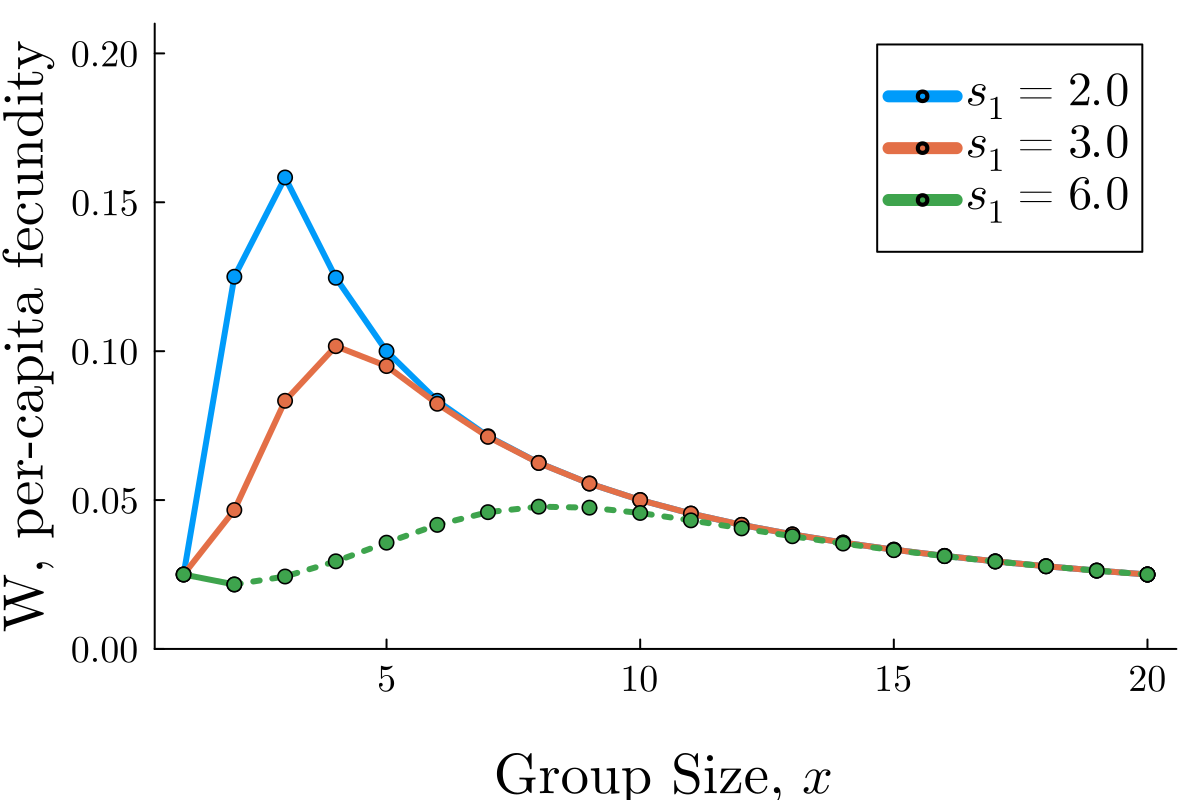

In [32]:
x = collect(1.0:1.0:20.0)
@unpack N1, N2 = params_simple
params = deepcopy(params_simple)

#params[:A1] = 3.0
s_list = [2.0, 3.0, 6.0]
fig = plot()
for (i, s) in enumerate(s_list)
    params[:s1] = s
    W = fun_W(x, N1, N2, params)
    #plot!(x,W, color = i, marker = :circle, label = L"$s = %$s$")
    Wabove = W[W .> W[1]]
    x_end_above = findfirst(<(W[1]),W)
    plot!(
        1:x_end_above, W[1:x_end_above], 
        color = i, marker = :circle,
        label = L"$s_1 = %$s$")
    plot!(
        x[x_end_above:end],W[x_end_above:end], 
        color = i, marker = :circle, linestyle = :dot,
        label = "")


end
plot!(ylim=[0.0,0.21])
plot!(xlab = "\n"*L"Group Size, $x$")
plot!(ylab = "W, per-capita fecundity")
#plot!(title = L"A_1 = 3.0, \alpha_1(1)=0.05")
savefig(fig, bif_fig_path*"W_simpleW_vs_s_smallA.pdf")
fig

## vs $\alpha_1(1)$

196nothing[0.15, 0.125, 0.11666666666666665, 0.10560344827586207, 0.0927027027027027, 0.08061375235025517, 0.07041055718475073, 0.06211511007112808, 0.05540841302712616, 0.049943158997824075, 0.04543238521399578, 0.041657958431888034, 0.03845809303410426, 0.03571291450460545, 0.03333278483742758, 0.031249779620108536, 0.029411675812794802, 0.027777741797180195, 0.026315774865009717, 0.02499999405218064]

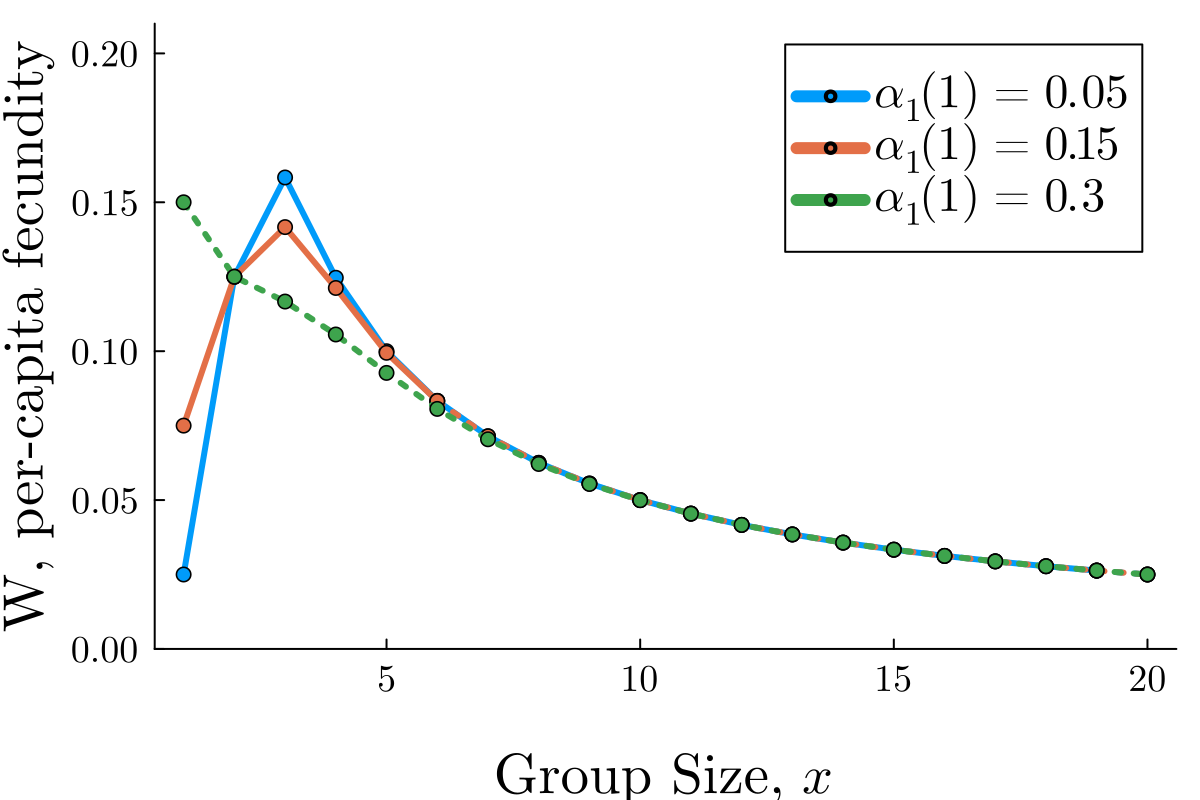

In [ ]:
x = collect(1.0:1.0:20.0)
@unpack N1, N2 = params_simple
params = deepcopy(params_simple)

α1_of_1list = [0.05, 0.15, 0.3]
fig = plot()
for (i, α1_of_1) in enumerate(α1_of_1list)
    params[:α1_of_1] = α1_of_1
    W = fun_W(x, N1, N2, params)
    #plot!(x,W, color = i, marker = :circle, label = L"$s = %$s$")
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)

    print(x_end_above)
    if x_end_above != nothing
        plot!(
            1:x_end_above, W[1:x_end_above], 
            color = i, marker = :circle,
            label = L"$\alpha_1(1) = %$α1_of_1$")
        plot!(
            x[x_end_above:end],W[x_end_above:end], 
            color = i, marker = :circle, linestyle = :dot,
            label = "")
    else
        print(W)
        plot!(x, W,color = i, marker = :circle, linestyle = :dot,
            label = "")
        plot!([],[],color = i, marker = :circle,
            label = L"$\alpha_1(1) = %$α1_of_1$")
    end


end
plot!(ylim=[0.0,0.21])
plot!(xlab = "\n"*L"Group Size, $x$")
plot!(ylab = "W, per-capita fecundity")
#plot!(ylim=[0,0.3])
#plot!(title = L"A_1 = 3.0, \alpha_1(1)=0.05")
savefig(fig, bif_fig_path*"W_simpleW_vs_alpha_smallA.pdf")
fig




hellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohellohello

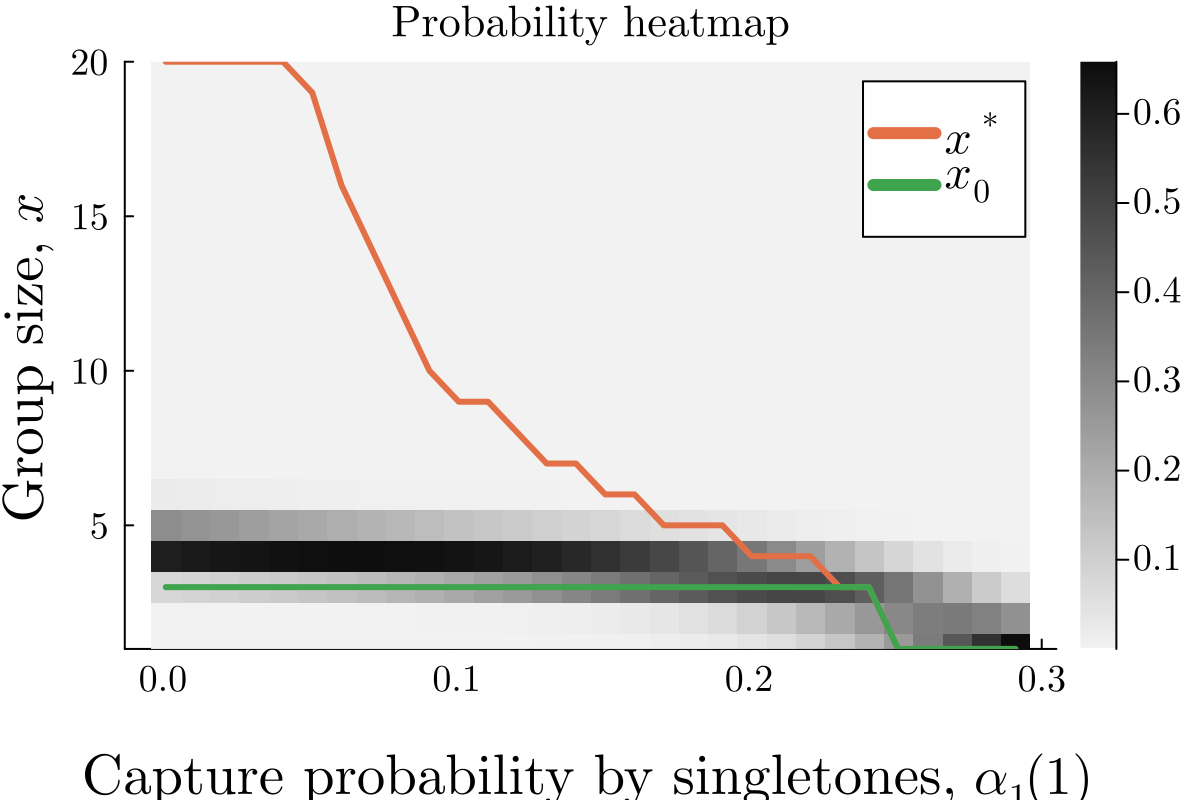

In [36]:
paramkey = :α1_of_1
paramvec = collect(0.001:0.01:0.3)

params = deepcopy(params_simple)
params[:x_max] = 20
@unpack P, N1, N2, x_max = params

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)



gmat = out_dict[:results_g]
hm = heatmap_bif_g1(gmat, P, N1, N2, paramkey, paramvec, params)


# fig = plot_line_g(
#     paramkey, x_max, paramvec, out_dict[:results_g], 
#     out_dict[:stability_results], P; group_size_last = 5
#     )
plot!(xlabel = "\n"*L"Capture probability by singletones, $\alpha_1(1)$")
# plot!(ylim=[-0.01,1.01])
# plot!(
#     fig, left_margin=6mm,  bottom_margin = 5mm,
#     legend = :top,
#     legend_column=3,)

savefig(hm, bif_fig_path*"equilibria_simpleW_vs_alpha_smallA.pdf")
hm



# Simple W

$W = A_1 \alpha_1(x)/x$

this is equivalent to setting $H_1(x) = H_2(x) = 0$, $N_2 = 0, N_1 = 1$, and $\beta_1 = 1$.

In [112]:

params_simple = Dict(
    :α1_of_1 => 0.05,
    :A1 => 3.0,
    :s1 => 2.0,
    :x_max => 10,
    :d => 100.0,
    :P => 10,#:P => 3.0,
    

    # parameters that don't matter:
    :N1 => 1.0,
    :N2 => 0, # turning off everything related to small prey
    :α2_of_1 => 0.95,
    :H1a => 0.0,
    :H1b => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A2 => 0.5, # doesn't matter
    :η2 => 0.5, # doesn't matter
    :β1 => 1.0,
    :β2 => 1.0, 
    :α2_fun_type => "constant",
    :Tg => 1,  
    :scale => 1.0 # eta1, eta2 don't matter here anyway, H = 0, so won't affect anything
)

Dict{Symbol, Any} with 20 entries:
  :A1          => 3.0
  :α1_of_1     => 0.05
  :Tg          => 1
  :H2b         => 0.0
  :d           => 100.0
  :β1          => 1.0
  :H1b         => 0.0
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 1.0
  :P           => 10
  :x_max       => 10
  :α2_of_1     => 0.95
  :η2          => 0.5
  :N2          => 0
  :N1          => 1.0
  :α2_fun_type => "constant"
  :β2          => 1.0

## Vs A1

In [113]:
function get_g_equilibria_2(P, N1, N2, params)
    """
    Finds all the g(x) equilibria for a certain P, N1, N2 combination.
    
    Assumes population sizes are constant.

    This version does not have S(1,y) in the denominator
    Returns gvec
    """
    x_max = params[:x_max]
    xvec = 1:x_max
    W = fun_W(xvec,N1,N2,params)
    S_of_1_x = fun_S_given_W(W[1], W, params)
    S_of_x_1 = 1 .- S_of_1_x

    # set up vector of coefficients for polynomial
    coeff_full = zeros(x_max+1)

    # do first couple terms
    full_product = 2*prod(xvec .* S_of_1_x)
    coeff_full[1] = -P*full_product # constant term
    coeff_full[2] = full_product # coeff of g(1)

    # Compute coefficients for g(1) for the 3rd term to the xm + 2 term (corresponding to g(2), g(3),)
    coefficients = [
        x * prod(S_of_x_1[2:x]) * prod(xvec[x+1:end] .* S_of_1_x[x+1:end]) 
        for x in 2:(x_max - 1)
            ]  
    coeff_full[3:end-1] = coefficients
    coeff_full[end] = x_max * prod(S_of_x_1)

    # Find roots
    roots_all = roots(Polynomials.Polynomial(coeff_full))
    
    # Filter real positive roots. there should only be one.
    g1 = real(filter(x -> isreal(x) && real(x) > 0, roots_all)[1])


    c = S_of_x_1 ./ ( xvec .* S_of_1_x )
    # Compute g(x) for each g1 root
    gvec = [prod(c[1:x] .* g1 ) for x in xvec] # this seems to generally manage issue of infs

    return gvec
end



get_g_equilibria_2 (generic function with 1 method)

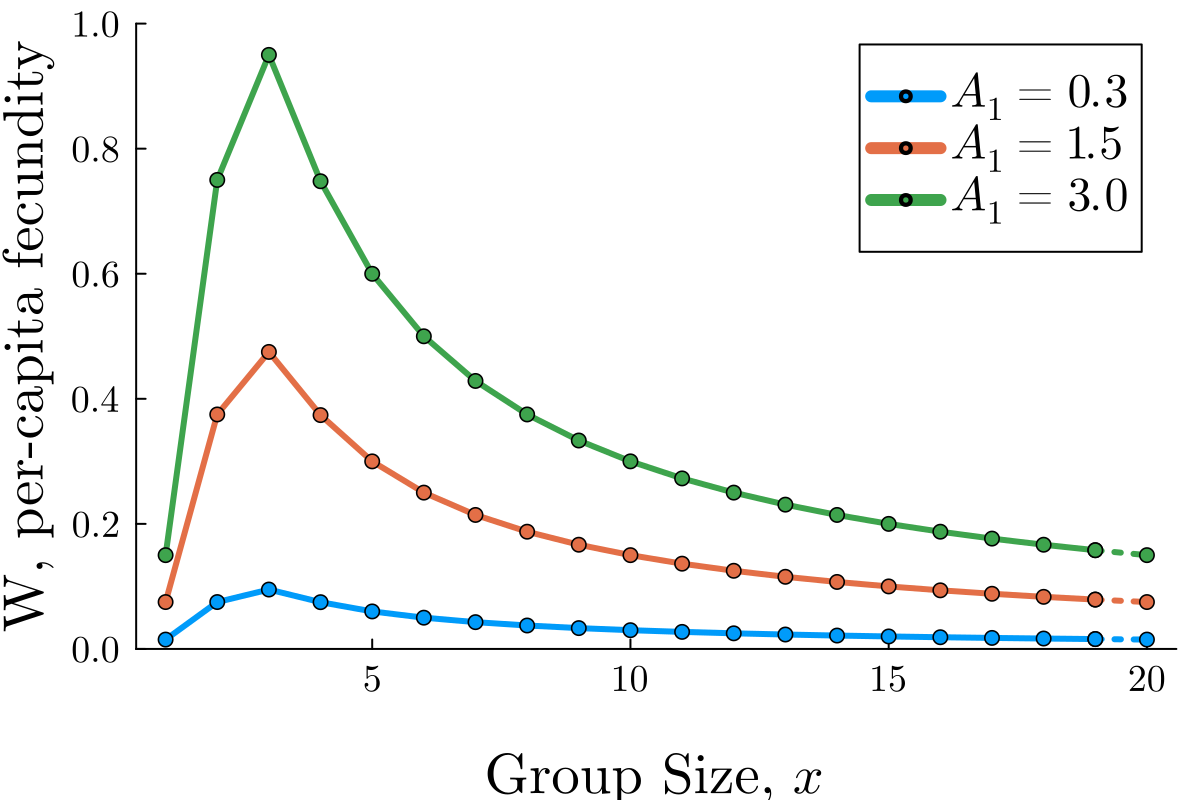

In [114]:
x = collect(1.0:1.0:20.0)
@unpack N1, N2 = params_simple

A1_list = [0.3, 1.5, 3.0]
params = deepcopy(params_simple)

fig = plot()
for (i, A1) in enumerate(A1_list)
    params[:A1] = A1
    W = fun_W(x, N1, N2, params)
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)
    plot!(
        1:x_end_above, W[1:x_end_above], 
        color = i, marker = :circle,
        label = L"$A_1 = %$A1$")
    plot!(
        x[x_end_above:end],W[x_end_above:end], 
        color = i, marker = :circle, linestyle = :dot,
        label = "")
    #plot!(x,W, color = i, marker = :circle, label = L"$A_1 = %$A1$")


end
plot!(ylim=[0.0,1.0])
plot!(xlab = "\n"*L"Group Size, $x$")
plot!(ylab = "W, per-capita fecundity")
#plot!(title = L"s_1 = 2.0, \alpha_1(1) = 0.05")
savefig(fig, bif_fig_path*"simpleW_vs_A1.pdf")
fig

# bookmark

heatmap_bif_g (generic function with 1 method)

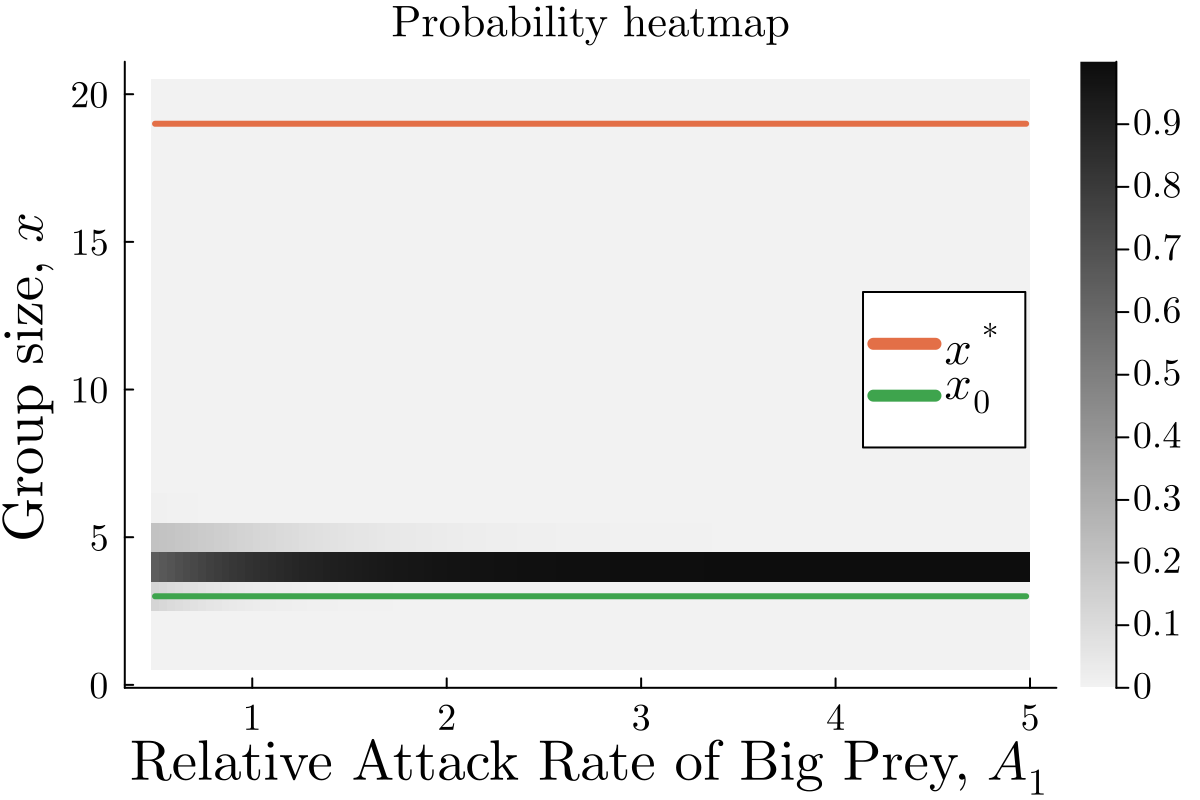

In [115]:
paramkey = :A1
paramvec = collect(0.5:0.04:5.0)
params[:x_max] = 20
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
gmat = out_dict[:results_g]

@unpack P, N1, N2, x_max = params

hm = heatmap_bif_g(gmat, P, N1, N2, paramkey, paramvec, params)
plot!(legend = :right)
savefig(hm, bif_fig_path*"equilibria_only_groups_simple_vs_A1.pdf")
hm

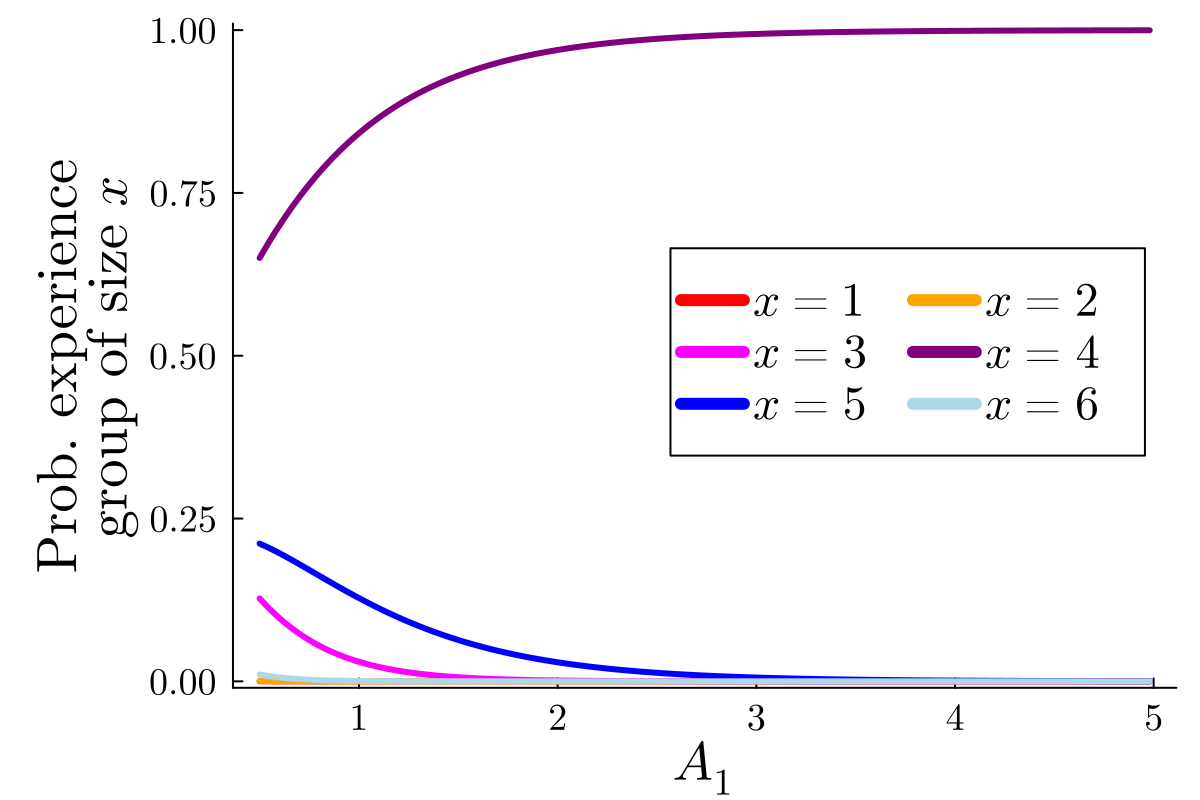

In [ ]:
#+
paramkey = :A1
paramvec = collect(0.5:0.04:5.0)
params = deepcopy(params_simple)
params[:x_max] = 20

@unpack P, N1, N2, x_max = params


out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)

g = out_dict[:results_g]


fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results], P; group_size_last = 6 
    )
plot!(xlabel = L"A_1")
plot!(ylim=[-0.01,1.01])
plot!(fig, left_margin=6mm, legend_column=2, legend = :right)

savefig(fig, bif_fig_path*"equilibria_only_groups_simple_vs_A1.pdf")
fig
=#


## Vs s

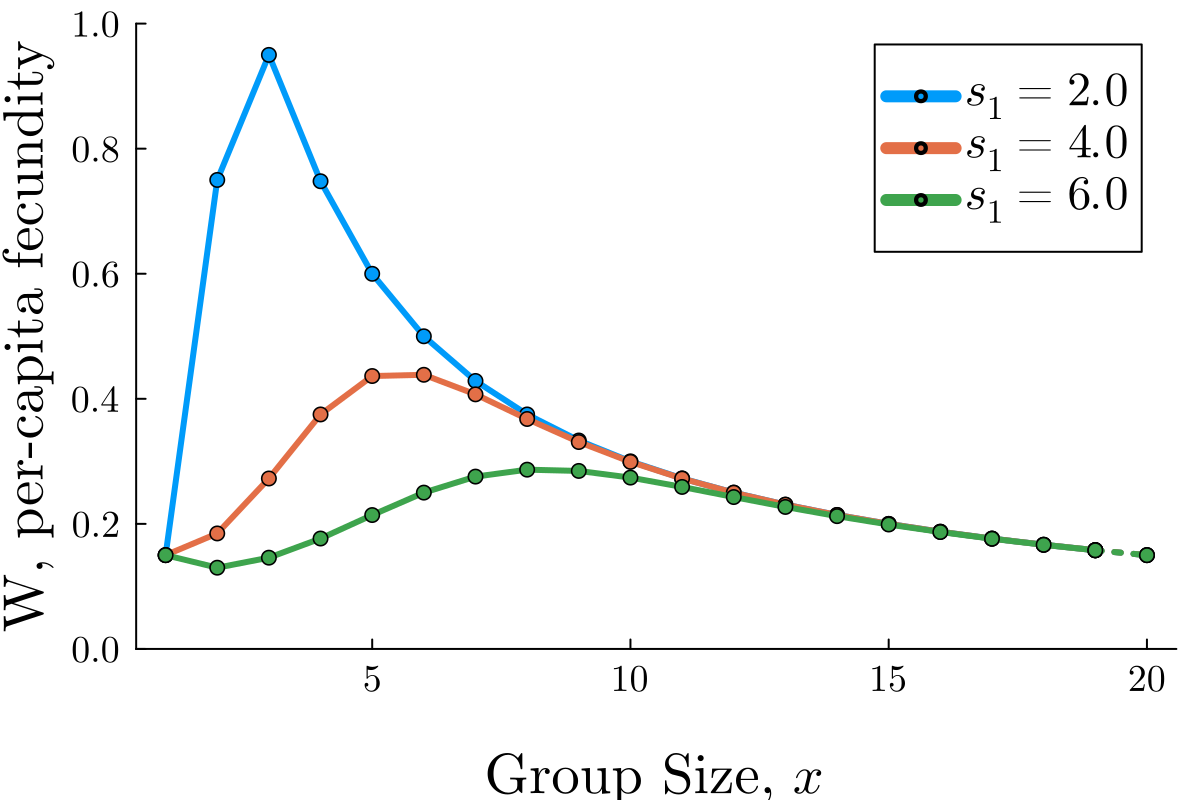

In [36]:
x = collect(1.0:1.0:20.0)
@unpack N1, N2 = params_simple
params = deepcopy(params_simple)

params[:A1] = 3.0
s_list = [2.0, 4.0, 6.0]
fig = plot()
for (i, s) in enumerate(s_list)
    params[:s1] = s
    W = fun_W(x, N1, N2, params)
    #plot!(x,W, color = i, marker = :circle, label = L"$s = %$s$")
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)
    plot!(
        1:x_end_above, W[1:x_end_above], 
        color = i, marker = :circle,
        label = L"$s_1 = %$s$")
    plot!(
        x[x_end_above:end],W[x_end_above:end], 
        color = i, marker = :circle, linestyle = :dot,
        label = "")


end
plot!(ylim=[0.0,1.0])
plot!(xlab = "\n"*L"Group Size, $x$")
plot!(ylab = "W, per-capita fecundity")
#plot!(title = L"A_1 = 3.0, \alpha_1(1)=0.05")
savefig(fig, bif_fig_path*"W_simpleW_vs_s.pdf")
fig

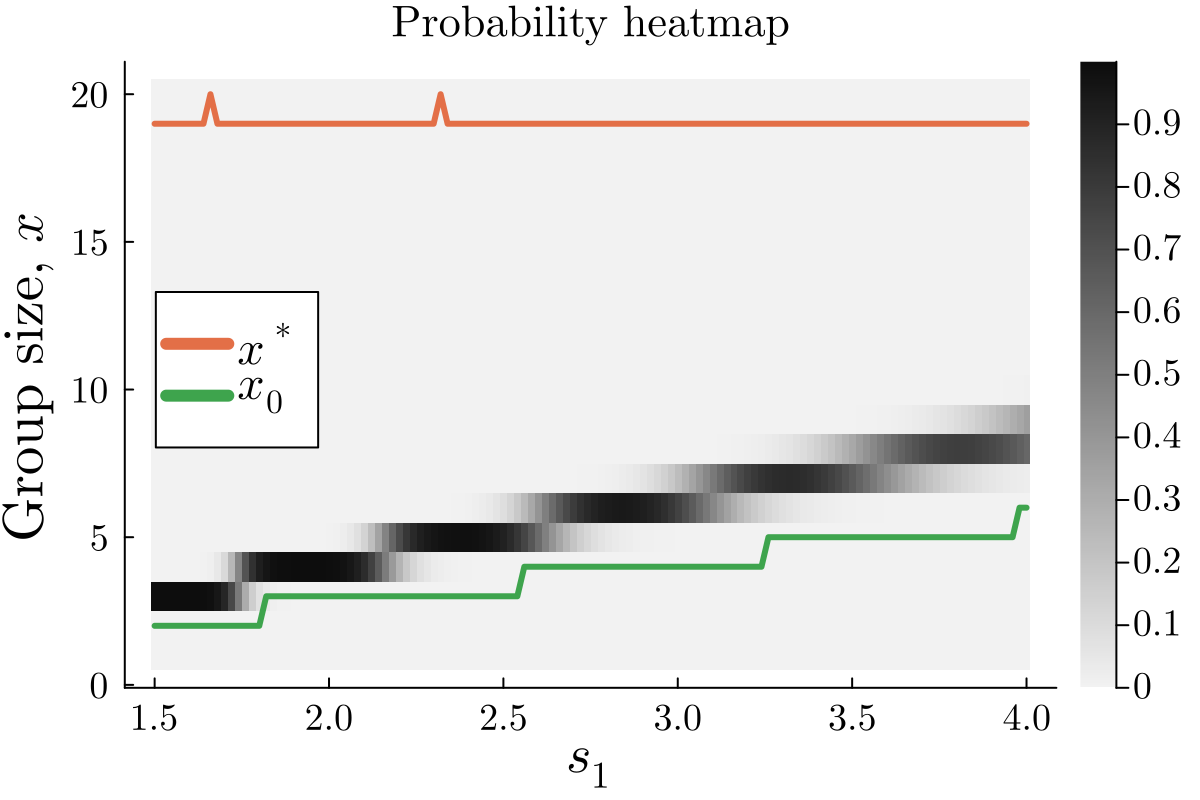

In [109]:
paramkey = :s1
paramvec = collect(1.5:0.02:4.0) 

params = deepcopy(params_simple)
params[:x_max] = 20
params[:A1] = 3.0
@unpack P, N1, N2, x_max = params
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
gmat = out_dict[:results_g]
hm = heatmap_bif_g(gmat, P, N1, N2, paramkey, paramvec, params)
plot!(legend=:left)
savefig(hm, bif_fig_path*"equilibria_simpleW_vs_s.pdf")
hm

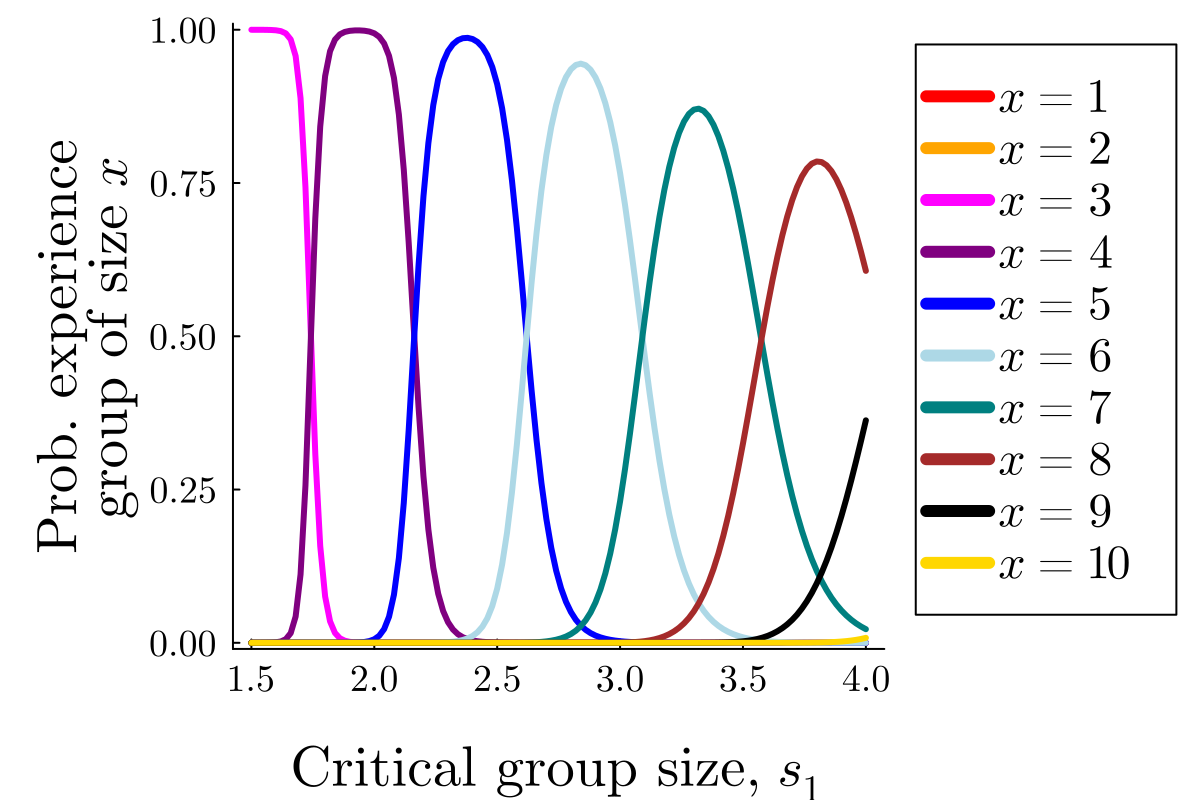

In [ ]:
#=
paramkey = :s1
paramvec = collect(1.5:0.02:4.0) 

params = deepcopy(params_simple)
params[:x_max] = 20
params[:A1] = 3.0
@unpack P, N1, N2, x_max = params

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results], P; group_size_last = 10
    )
plot!(xlabel = "\n"*L"Critical group size, $s_1$")
plot!(ylim=[-0.01,1.01])
plot!(
    fig, left_margin=6mm, 
    legend = :outertopright)

savefig(fig, bif_fig_path*"equilibria_simpleW_vs_s.pdf")
fig

=#

## vs $\alpha_1(1)$

196nothing[0.8999999999999999, 0.75, 0.6999999999999998, 0.6336206896551724, 0.5562162162162162, 0.483682514101531, 0.42246334310850436, 0.37269066042676846, 0.33245047816275697, 0.2996589539869444, 0.2725943112839747, 0.2499477505913282, 0.23074855820462556, 0.21427748702763272, 0.19999670902456548, 0.1874986777206512, 0.1764700548767688, 0.16666645078308118, 0.1578946491900583, 0.14999996431308385]

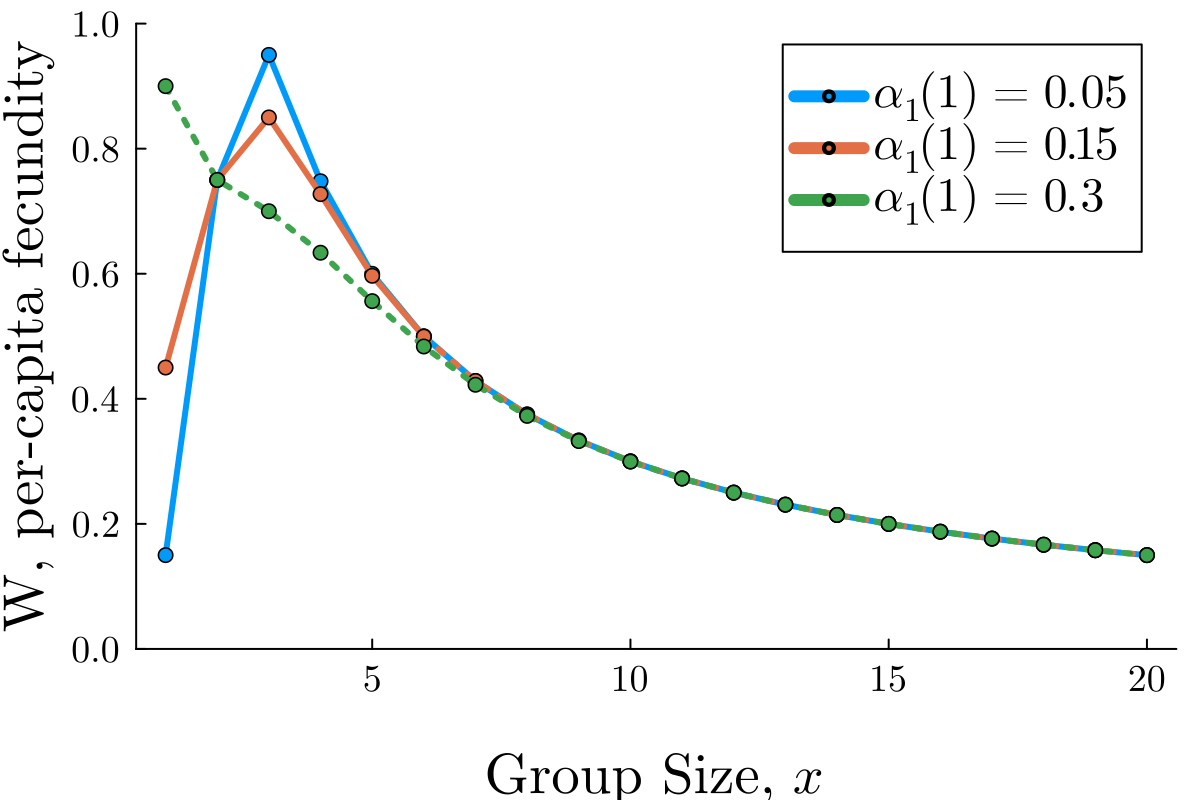

In [98]:
x = collect(1.0:1.0:20.0)
@unpack N1, N2 = params_simple
params = deepcopy(params_simple)

α1_of_1list = [0.05, 0.15, 0.3]
fig = plot()
for (i, α1_of_1) in enumerate(α1_of_1list)
    params[:α1_of_1] = α1_of_1
    W = fun_W(x, N1, N2, params)
    #plot!(x,W, color = i, marker = :circle, label = L"$s = %$s$")
    Wabove = W[W .> W[1]]
    x_end_above = findlast(>(W[1]),W)

    print(x_end_above)
    if x_end_above != nothing
        plot!(
            1:x_end_above, W[1:x_end_above], 
            color = i, marker = :circle,
            label = L"$\alpha_1(1) = %$α1_of_1$")
        plot!(
            x[x_end_above:end],W[x_end_above:end], 
            color = i, marker = :circle, linestyle = :dot,
            label = "")
    else
        print(W)
        plot!(x, W,color = i, marker = :circle, linestyle = :dot,
            label = "")
        plot!([],[],color = i, marker = :circle,
            label = L"$\alpha_1(1) = %$α1_of_1$")
    end


end
plot!(ylim=[0.0,1.0])
plot!(xlab = "\n"*L"Group Size, $x$")
plot!(ylab = "W, per-capita fecundity")
#plot!(title = L"A_1 = 3.0, \alpha_1(1)=0.05")
savefig(fig, bif_fig_path*"W_simpleW_vs_alpha.pdf")
fig

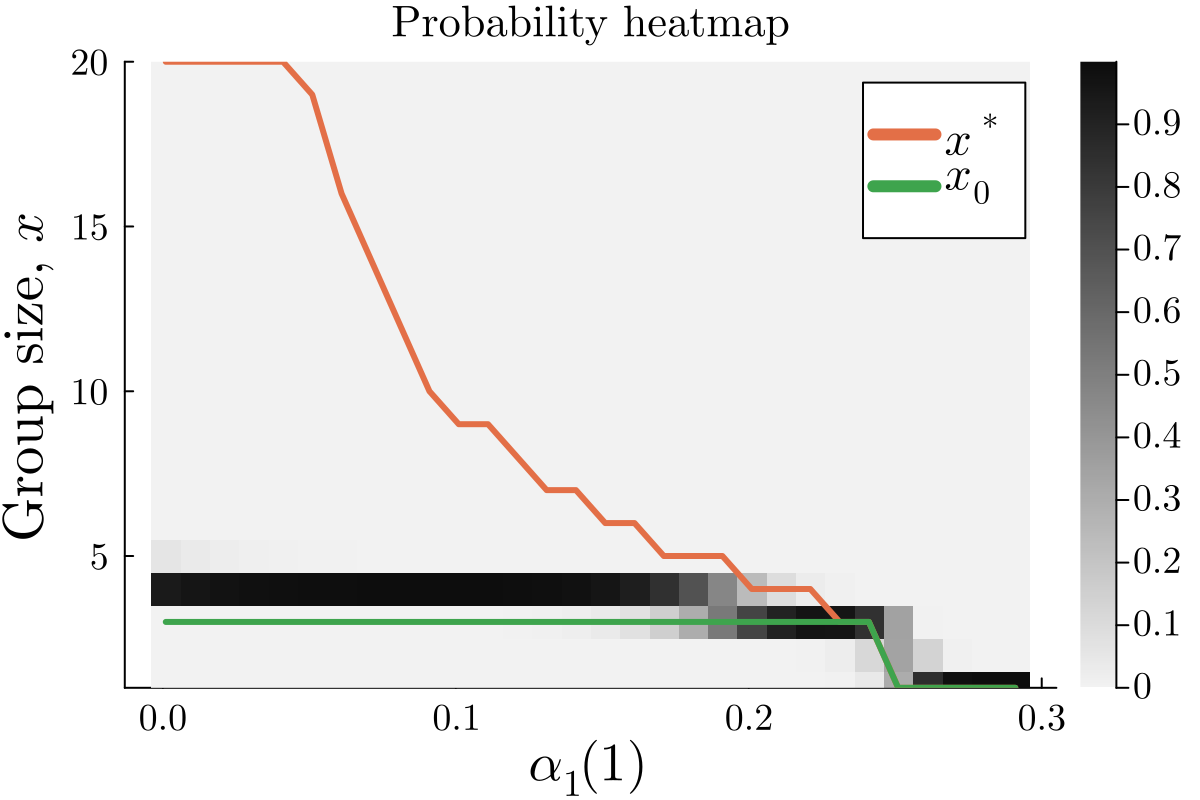

In [106]:
paramkey = :α1_of_1
paramvec = collect(0.001:0.01:0.3)

params = deepcopy(params_simple)
params[:x_max] = 20
params[:A1] = 3.0
@unpack P, N1, N2, x_max = params
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
gmat = out_dict[:results_g]
hm = heatmap_bif_g(gmat, P, N1, N2, paramkey, paramvec, params)
plot!(legend=:topright)
plot!(ylims = [1,params[:x_max]])
savefig(hm, bif_fig_path*"equilibria_simpleW_vs_alpha.pdf")

hm

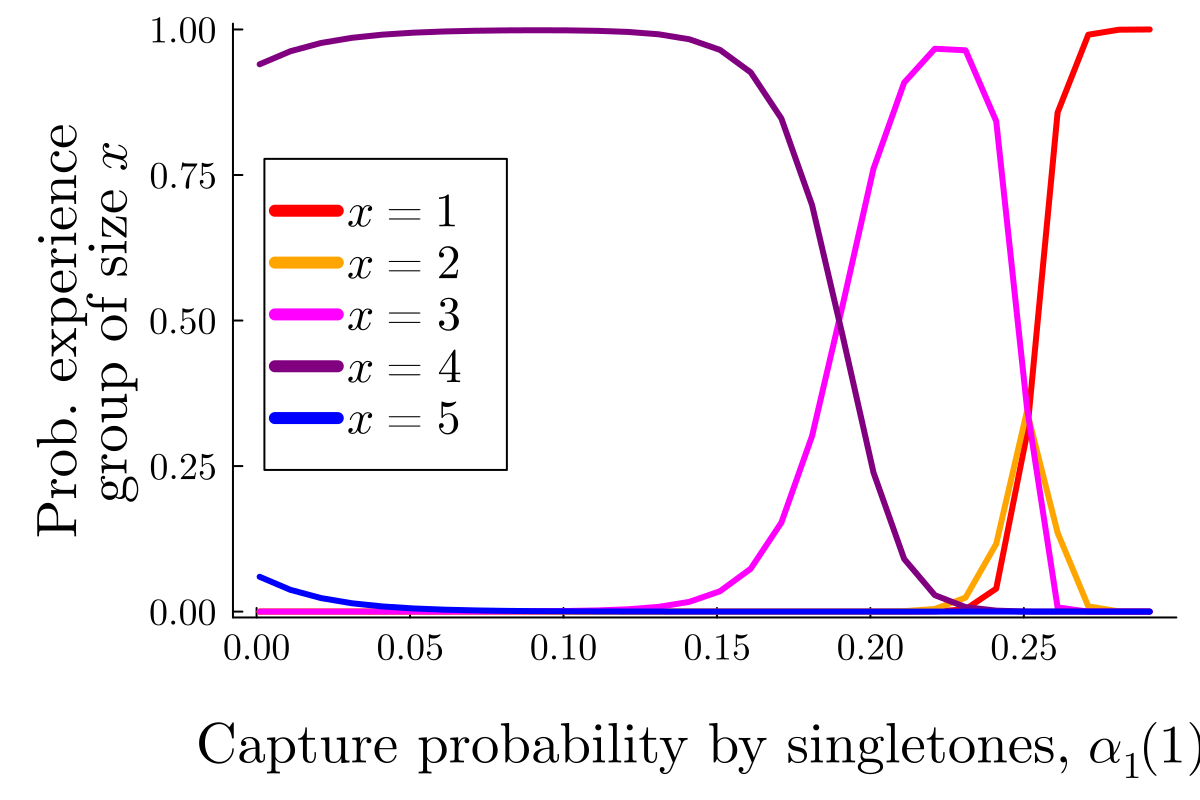

In [ ]:
#=
paramkey = :α1_of_1
paramvec = collect(0.001:0.01:0.3)

params = deepcopy(params_simple)
params[:x_max] = 20
@unpack P, N1, N2, x_max = params

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params)
fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results], P; group_size_last = 5
    )
plot!(xlabel = "\n"*L"Capture probability by singletones, $\alpha_1(1)$")
plot!(ylim=[-0.01,1.01])
plot!(
    fig, left_margin=6mm,  bottom_margin = 5mm,
    legend = :left)

savefig(fig, bif_fig_path*"equilibria_simpleW_vs_alpha.pdf")
fig
=#



# Type I

In [9]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => 0.01,
    :d => 100.0,
    :scale => 5.0,
    :P => 3.0,
    :N1 => 0.2,
    :N2 => 0.6
)


Dict{Symbol, Any} with 19 entries:
  :A1          => 0.6
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 0.0
  :Tg          => 0.01
  :d           => 100.0
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 5.0
  :P           => 3.0
  :x_max       => 5
  :α2_of_1     => 0.95
  :η2          => 0.6
  :N2          => 0.6
  :N1          => 0.2
  :α2_fun_type => "constant"
  :s2          => 2.0

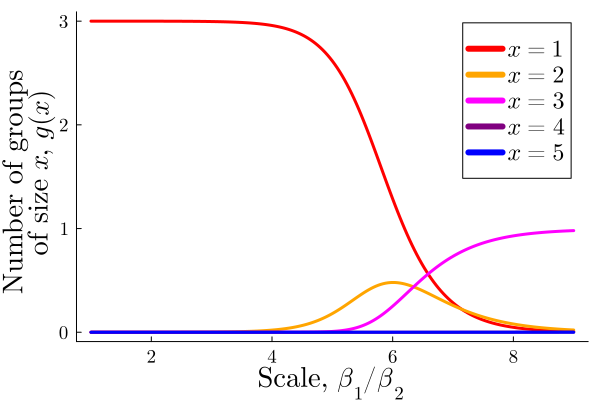

In [14]:
paramkey = :scale
paramvec = collect(1.0:0.04:9.0)
@unpack P, N1, N2 = params_base
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, params_base[:x_max], paramvec, out_dict[:results_g], 
    out_dict[:stability_results],
    )
plot!(
    ylabel = "Number of groups \n of size "*L"$x$, $g(x)$",
    left_margin = 2mm)

savefig(fig, bif_fig_path*"equilibria_only_groups_vs_scale_t1.pdf")

fig

In [11]:
(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))

0

# Trying to find instability

0

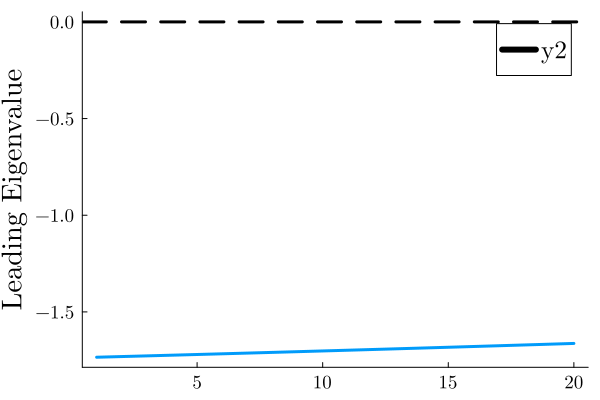

In [35]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.5,
    :A1 => 0.1,
    :A2 => 0.8,
    :η2 => 0.8,
    :β2 => 0.1,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => 0.01,
    :d => 100.0,
    :scale => 5.0,
    :P => 0.2,
    :N1 => 0.1,
    :N2 => 0.9
)

paramkey = :scale
paramvec = collect(1.0:0.04:20.0)
@unpack P, N1, N2 = params_base
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, params_base[:x_max], paramvec, out_dict[:results_g], 
    out_dict[:stability_results],
    )
plot!(ylabel = "Density of groups \n of size "*L"$x$, $g(x)$")


fig


(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))
plt

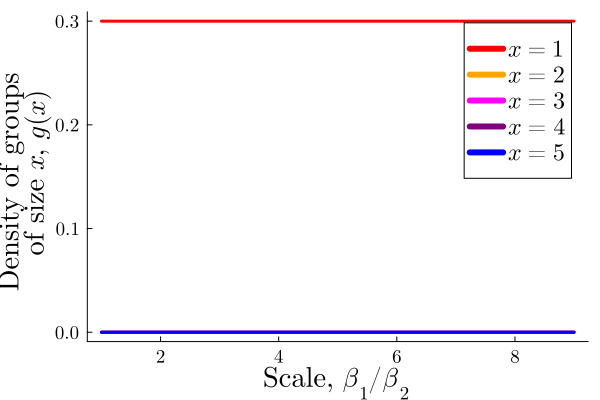